In [201]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%run imports_notebook.py

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model = model.to(device)

In [4]:
import copy

In [5]:
with open('murder.txt') as f:
    text_book = f.read()
    text_book = ' '.join(text_book.split())
    tokens_str_book = tokenizer.tokenize(text_book)
    input_ids_book = tokenizer(text_book, return_tensors='pt').input_ids[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (91920 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
len(input_ids_book)

91920

In [7]:
ak = {'debug': True}
outputs = model(input_ids_book[None, :40].to(device), ak=ak)
Q, K, V = ak['QKV']

ak = {'debug': True}
outputs = model(input_ids_book[None, :41].to(device), ak=ak)
Q1, K1, V1 = ak['QKV']
assert (Q1[..., -2, :]- Q[..., -1, :]).abs().max()<1e-3

In [8]:
Q.shape, Q1.shape

(torch.Size([1, 6, 12, 40, 64]), torch.Size([1, 6, 12, 41, 64]))

In [9]:
(V - V1[:, :, :, :40, :]).abs().max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [228]:
n_context = 40
n_tokens = 1000
Qs, Ks, Vs = [], [], []
for i in tqdm(range(0, 1000)):
    ak = {'debug': True, 'use_pos': True}
    outputs = model(input_ids_book[None, i*n_context: (i+1)*n_context].to(device), ak=ak)
    Q, K, V = ak['QKV']
    Q, K, V = (a.detach() for a in [Q, K, V])
    Qs.append(Q); Ks.append(K); Vs.append(V)
Qs, Ks, Vs = torch.cat(Qs, dim=0), torch.cat(Ks, dim=0), torch.cat(Vs, dim=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
Q, K, V = Qs[-1], Ks[-1], Vs[-1]
A = Q@K.transpose(-1, -2)
A_sm = sm(A, 1/8., -1)

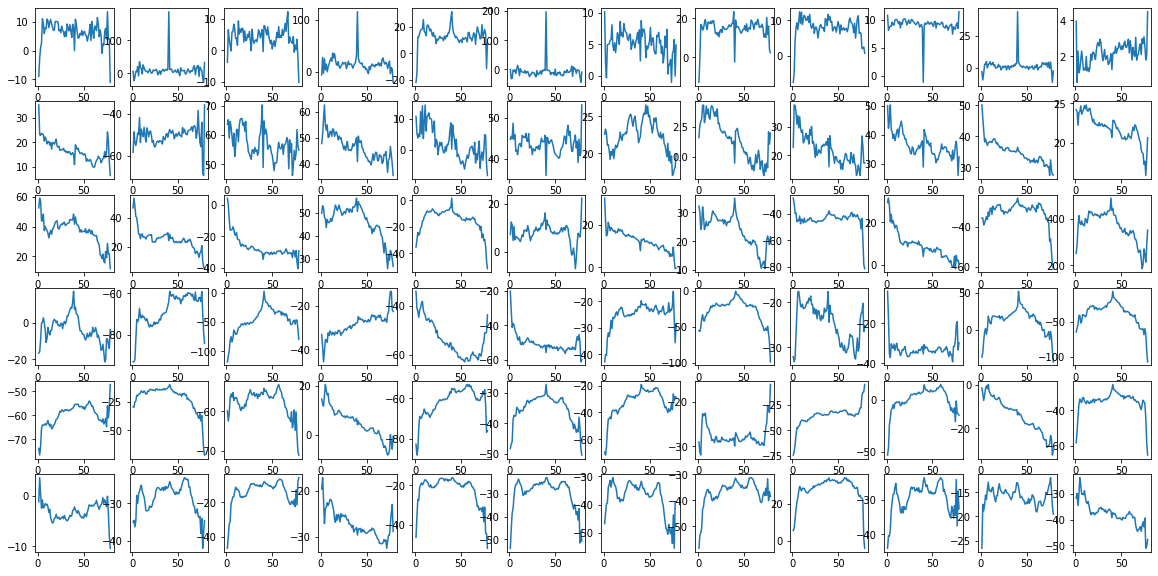

In [12]:
plt.figure(figsize=(20, 10))
i=1
for idx_layer in range(6):
    for idx_head in range(12):
        plt.subplot(6, 12, i)
        # plt.imshow(to_np(A[idx_layer, idx_head]))
        
        a = np.array([A[idx_layer, idx_head].diagonal(j).mean().item() for j in range(-40, 40)])
        plt.plot(a)
        i+=1

In [13]:
import wandb

In [229]:
import torchvision
def stack2d(a, padding=0, pad_val=None):
    # n_layers, n_heads, n, m
    # a = torch.cat(a.split(1, dim=1), dim=-1)[:, 0]
    # a = torch.cat(a.split(1, dim=0), dim=-2)[0]
    nl, nh = a.shape[:2]
    if pad_val is None:
        pad_val=a.max()
    a = torchvision.utils.make_grid(a.transpose(0, 1).transpose(-1, -2).reshape(nl*nh, 1, *a.shape[-2:]), 
                                    nrow=nl, padding=padding, pad_value=pad_val)[0].T
    return a

torch.Size([6, 12, 80, 64])


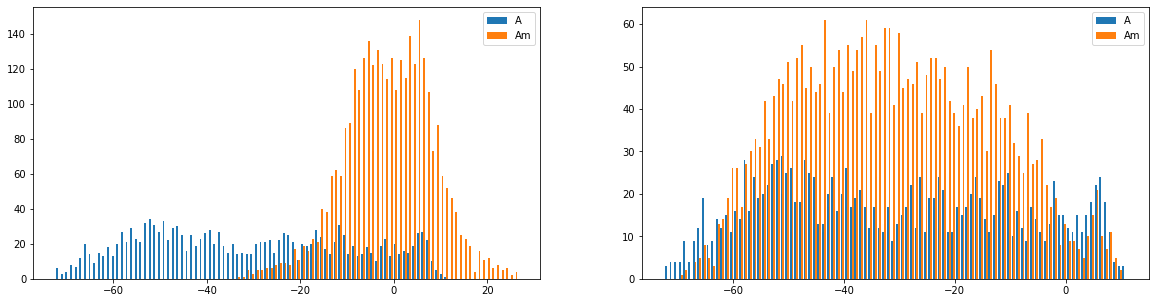

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900


In [230]:
torch.manual_seed(0)
n_memories = 80
alpha = 1.
use_adaptive_alpha = True
hm = HopfieldMemory((6, 12, n_memories, 64), alpha=alpha, use_uniform_steps=0., rigidity=1.).to(device)
hm.reset(1.)

print(hm.Km.shape)
# beta1, beta2 = 1/50., 1000.
beta1, beta2 = 100., 1000.

n_viz_steps = 10
use_wandb = False

idx_layer_viz = 1
idx_head_viz = 11

if use_wandb:
    wandb.init()

Q, K, V = Qs[-1], Ks[-1], Vs[-1]
A = Q@K.transpose(-1, -2)
Am = Q@hm.Km.transpose(-1, -2)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist([to_np(A[idx_layer_viz, idx_head_viz].flatten()), to_np(Am[idx_layer_viz, idx_head_viz].flatten())],
          bins=100, label=['A', 'Am']); plt.legend()

hm.Km.data[...] = hm.Km.data[...]*K.std(dim=-2, keepdim=True)+K.mean(dim=-2, keepdim=True)
A = Q@K.transpose(-1, -2)
Am = Q@hm.Km.transpose(-1, -2)
plt.subplot(122)
plt.hist([to_np(A[idx_layer_viz, idx_head_viz].flatten()), to_np(Am[idx_layer_viz, idx_head_viz].flatten())],
          bins=100, label=['A', 'Am']); plt.legend()

plt.show()

Amsmsm_sum = torch.zeros(6, 12, n_context, n_memories).to(device)

data = defaultdict(lambda : [])
for i, (Q, K, V) in tqdm(enumerate(zip(Qs, Ks, Vs)), total=len(Qs)):
    wlog = {}
    # Q, K, V = Qs[0], Ks[0], Vs[0]
    T = K
    
    A = T@K.transpose(-1, -2)
    Am = T@hm.Km.transpose(-1, -2)
    
    n_unique_T = calc_n_unique_vectors(T)
    n_unique_Km = calc_n_unique_vectors(hm.Km)
    
    spread_T = (T[..., :, None, :]-T[..., None, :, :]).norm(dim=-1).mean(dim=(-1,-2))
    spread_Km = (hm.Km[..., :, None, :]-hm.Km[..., None, :, :]).norm(dim=-1).mean(dim=(-1,-2))
    
    Am = (Am-Am.mean(dim=(-1, -2), keepdim=True))/Am.std(dim=(-1, -2), keepdim=True)
    activation, rigid_activation, step_size = hm.set_target_with_data(T, None, beta1=beta1, beta2=beta2, temp_normalize=True)
    
    if n_viz_steps is not None and i%(len(Qs)//n_viz_steps)==0:
        print(f'Step {i}')
        # plt.hist([to_np(A[idx_layer_viz, idx_head_viz].flatten()), to_np(Am[idx_layer_viz, idx_head_viz].flatten())],
                  # bins=100, label=['A', 'Am']); plt.legend()
        # wlog['dist'] = plt.gcf()
        
        viz.viz_Am(Am[2, 11], beta1, beta2)
        wlog['Am 2, 11'] = plt.gcf()
        viz.viz_Am(Am[1, 11], beta1, beta2)
        wlog['Am 1, 11'] = plt.gcf()

        # viz.viz_Am(Am[idx_layer_viz, idx_head_viz], beta1, beta2)
        # wlog['Am'] = plt.gcf()
        viz.viz_Q_Km(T[idx_layer_viz, idx_head_viz], hm.Km[idx_layer_viz, idx_head_viz])
        wlog['T, Km'] = plt.gcf()
        
        plt.figure(figsize=(20, 5))
        plt.subplot(121); plt.title('unique Km'); plt.ylabel('layers'); plt.xlabel('heads')
        plt.imshow(to_np(n_unique_Km), vmin=0, vmax=n_memories); plt.colorbar()
        plt.subplot(122); plt.title('unique T'); plt.ylabel('layers'); plt.xlabel('heads')
        plt.imshow(to_np(n_unique_T), vmin=0, vmax=n_memories); plt.colorbar()
        wlog['unique Kms, Ts'] = plt.gcf()
        
        plt.figure(figsize=(20, 10))
        plt.title('A'); plt.ylabel('layers/Q'); plt.xlabel('heads/K')
        plt.imshow(to_np(stack2d(A, padding=1))); plt.colorbar()
        wlog['A'] = plt.gcf()
        
        plt.figure(figsize=(20, 10))
        plt.title('Am'); plt.ylabel('layers/Q'); plt.xlabel('heads/Km')
        plt.imshow(to_np(stack2d(Am, padding=1))); plt.colorbar()
        wlog['Am'] = plt.gcf()
        
        # data['Am'].append(Am)
    Amsmsm_sum += sm(sm(Am, beta1, -1), beta2, -2)

    hm.step()
    
    data['activation'].append(activation)
    data['rigid_activation'].append(rigid_activation)
    data['step_size'].append(step_size)


#         data['spread_T'].append(spread_T)
#         data['spread_Km'].append(spread_Km)
    data['n_unique_T'].append(n_unique_T)
    data['n_unique_Km'].append(n_unique_Km)

    if use_wandb:
        wandb.log(copy.copy(wlog))
        
    for key, value in wlog.items():
        if isinstance(value, plt.Figure):
            plt.close(value)

for key, value in data.items():
    if isinstance(value[0], torch.Tensor):
        data[key] = torch.stack(value, dim=0)

# wandb.finish()

In [245]:
a = Amsmsm_sum
plt.figure(figsize=(20, 5))
plt.imshow(to_np(stack2d(Amsmsm_sum/1000., padding=1.))); plt.colorbar()

TypeError: new_full(): argument 'size' must be tuple of ints, but found element of type float at pos 2

<Figure size 1440x360 with 0 Axes>

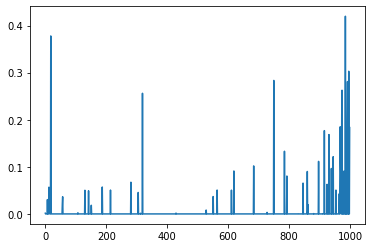

In [177]:
plt.plot(to_np(a[:, 2, 11, 6]));

In [178]:
Q, K, V = Qs[0], Ks[0], Vs[0]

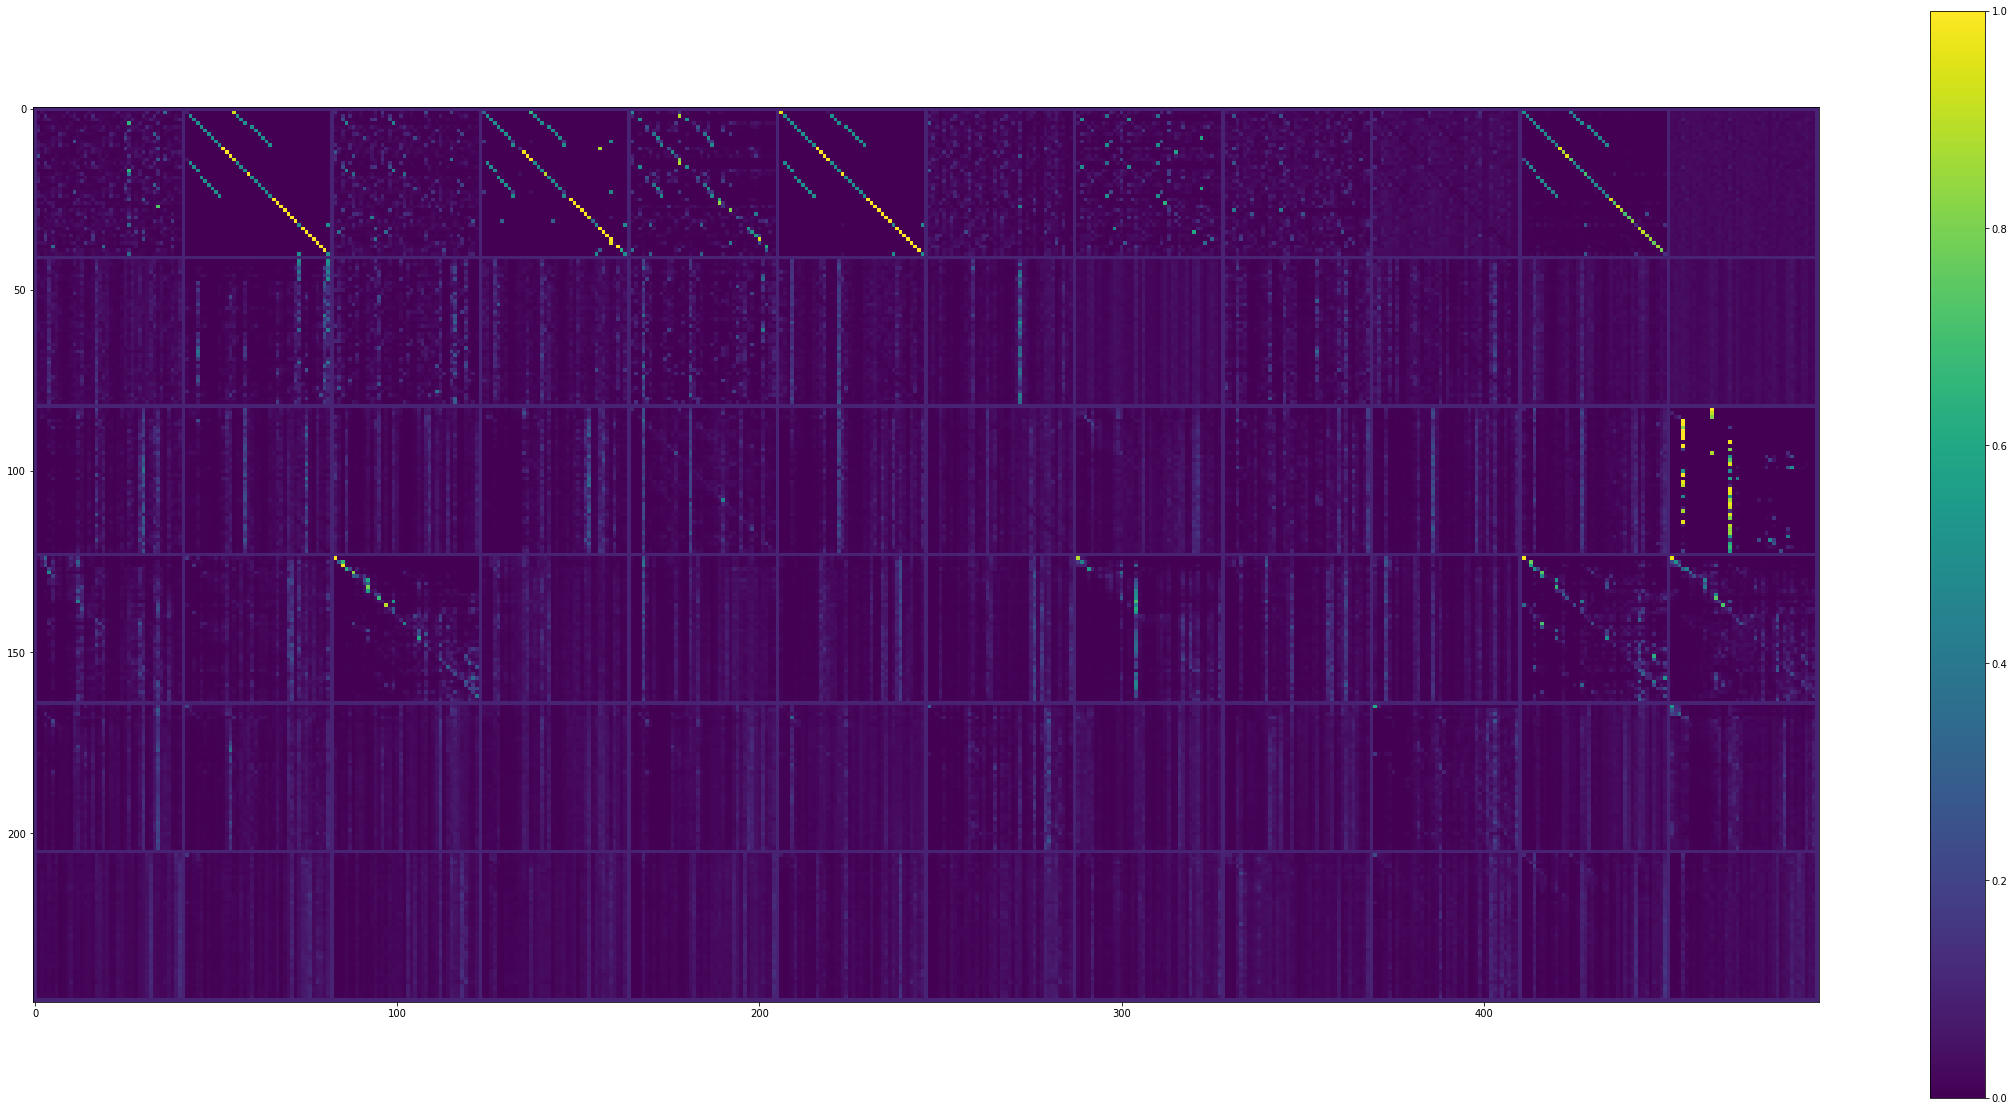

In [200]:
plt.figure(figsize=(40, 20))
a = (Q@K.transpose(-1, -2))
# a = sm(a, 1000., -1)
a = sm(a, 1/8., -1)
plt.imshow(to_np(stack2d(a, padding=1, pad_val=.1))); plt.colorbar()

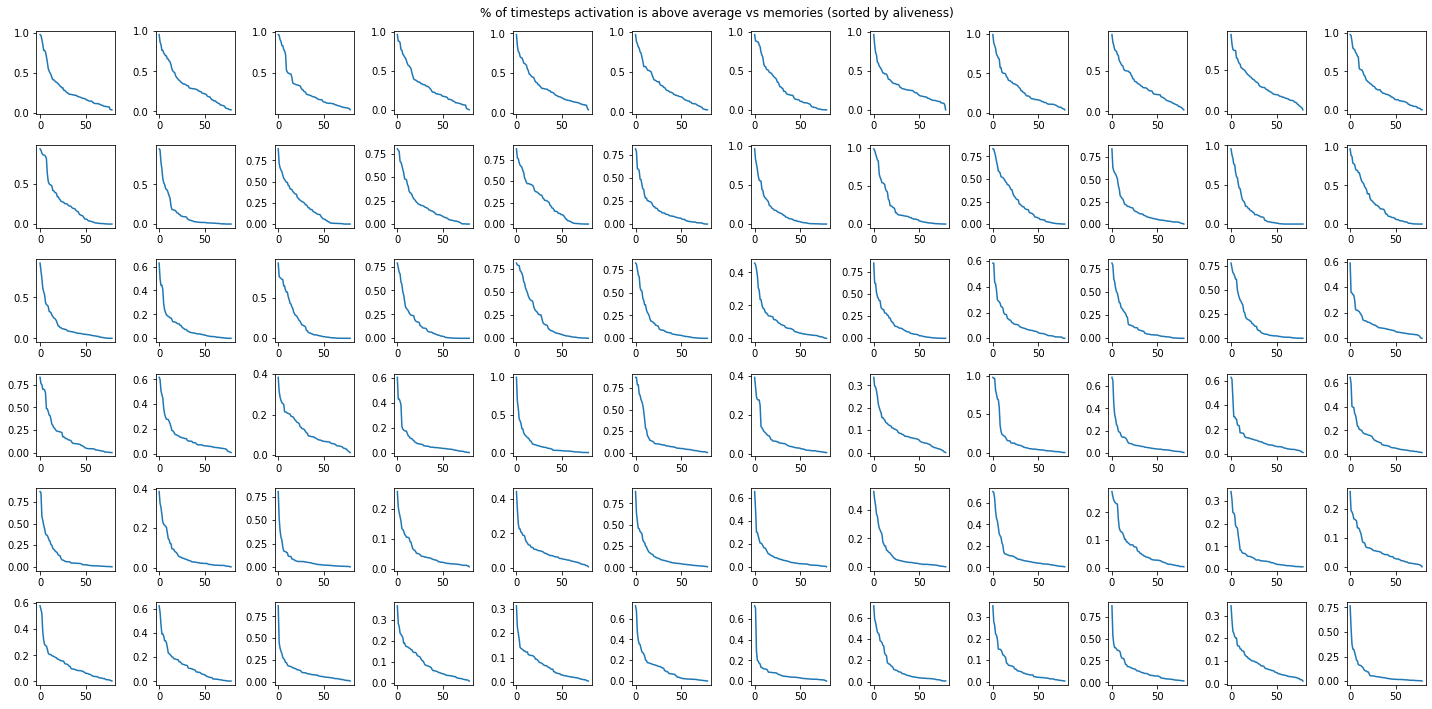

In [166]:
a = data['step_size']
b = (a>a.mean(dim=(-1), keepdim=True)).float().mean(dim=0)
# b = a.mean(dim=0)
# b = (a>a.median(dim=(-1), keepdim=True).values).float().mean(dim=0)
b = b.sort(dim=-1, descending=True).values

fig = plt.figure(figsize=(20, 10))
i=0
for idx_layer in range(6):
    for idx_head in range(12):
        i+=1
        plt.subplot(6, 12, i)
        plt.plot(to_np(b[idx_layer,idx_head]), label=f'{idx_layer} {idx_head}')
        # plt.yscale('log')
        # plt.ylim(b.min().item(), b.max().item())

plt.suptitle('% of timesteps activation is above average vs memories (sorted by aliveness)')
plt.tight_layout()
        
# wandb.log({'step_size vs time': wandb.Image(plt)})

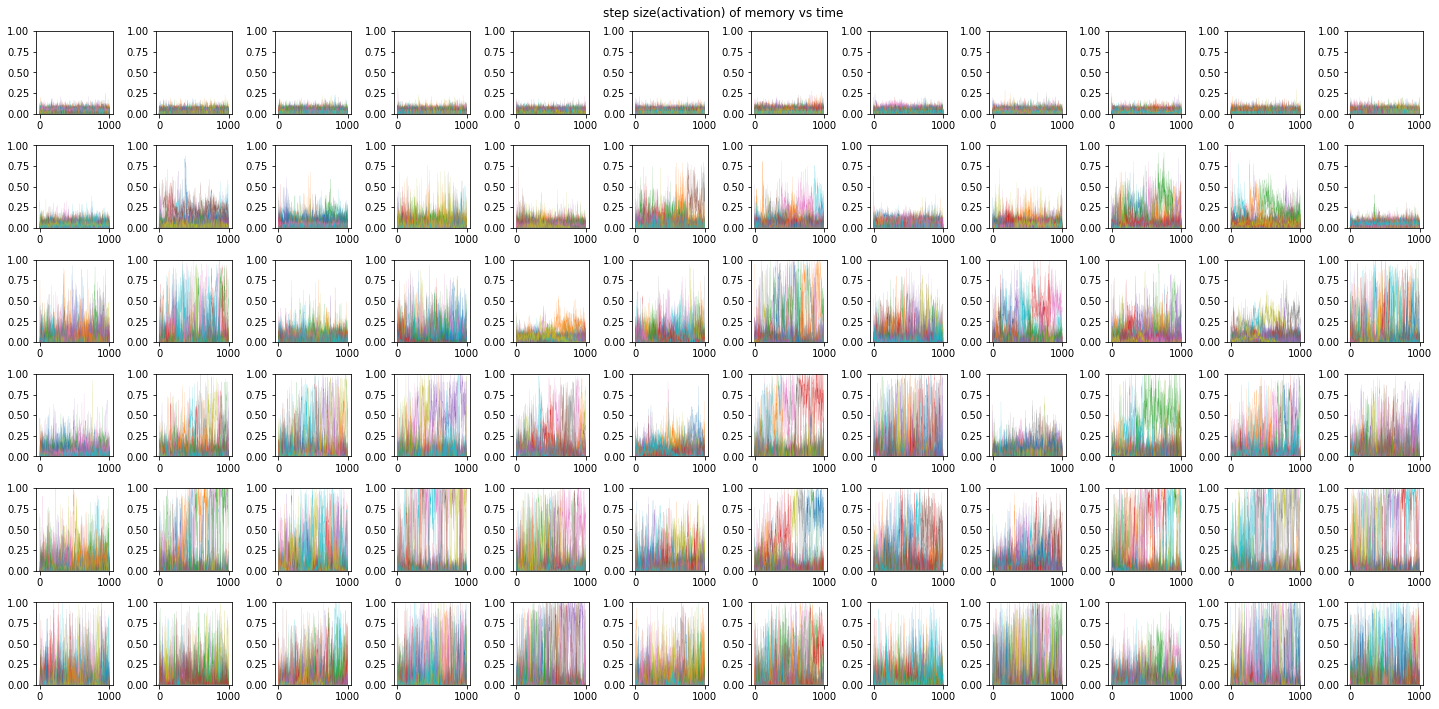

In [163]:
a = data['step_size']
plt.figure(figsize=(20, 10))
i=0
for idx_layer in range(6):
    for idx_head in range(12):
        i+=1
        plt.subplot(6, 12, i)
        plt.plot(to_np(a[:, idx_layer,idx_head]), label=f'{idx_layer} {idx_head}', linewidth=0.1)
        plt.ylim(0, a.max().item())

plt.suptitle('step size(activation) of memory vs time')
plt.tight_layout()

wandb.log({'step_size vs time': wandb.Image(plt)})

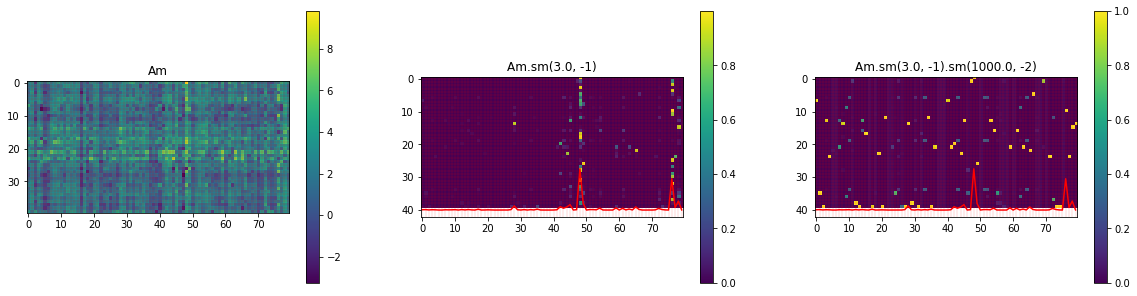

In [401]:
viz.viz_Am(Am[0, 11], beta1, beta2)

In [164]:
wandb.finish()

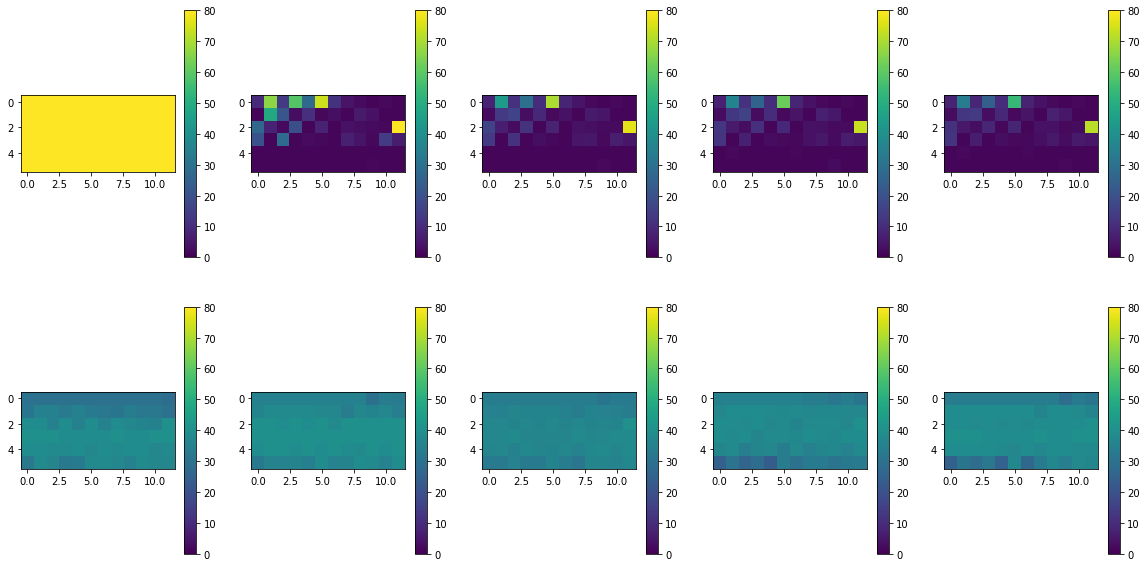

In [117]:
plt.figure(figsize=(20, 10))
n_viz = 5
a = data['n_unique_Km']
b = data['n_unique_T']
for ii, i in enumerate(range(0, len(a), len(a)//n_viz)):
    plt.subplot(2, n_viz, ii+1)
    plt.imshow(to_np(a[i]), vmin=0, vmax=80);plt.colorbar()
    plt.subplot(2, n_viz, ii+1+n_viz)
    plt.imshow(to_np(b[i]), vmin=0, vmax=80);plt.colorbar()

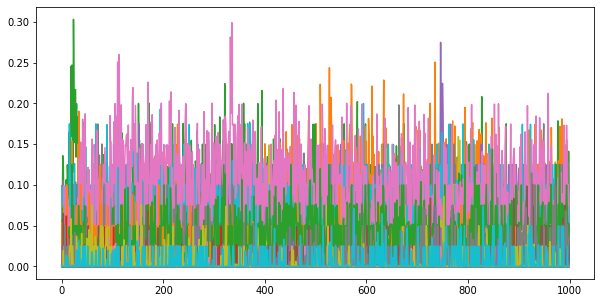

In [411]:
plt.figure(figsize=(10, 5))
a = data['activation']
plt.plot(to_np(a[:, 0, 2, :]));

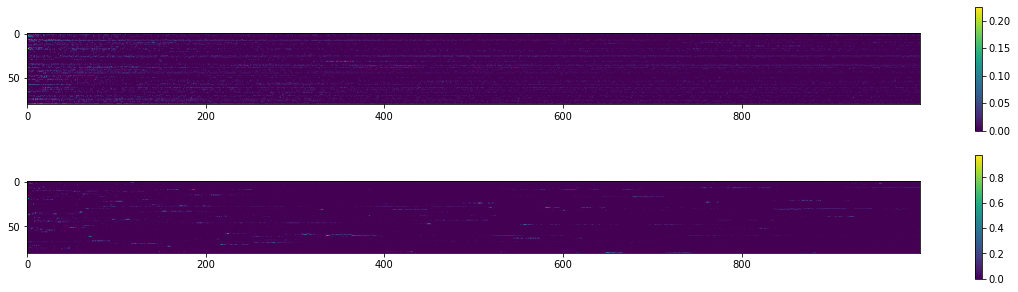

In [100]:
a = data['rigid_activation']
plt.figure(figsize=(20, 5))
plt.subplot(211)
plt.imshow(to_np(a[:, 1, 11, :].T)); plt.colorbar()
plt.subplot(212)
plt.imshow(to_np(a[:, 2, 11, :].T)); plt.colorbar()

In [115]:
a = data['step_size']
a.mean(dim=0).mean(dim=-1)

tensor([[0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125, 0.0125, 0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125, 0.0125, 0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125, 0.0125, 0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125, 0.0125, 0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125, 0.0125, 0.0125],
        [0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
         0.0125, 0.0125, 0.0125]], device='cuda:0')

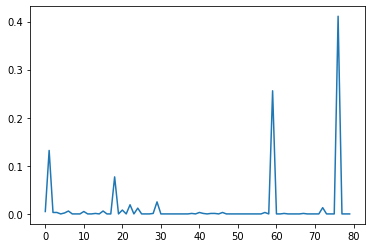

In [23]:
b = a[:, 0, 0, :].argmax(dim=-1).bincount(minlength=80)/len(a)
plt.plot(to_np(b))

In [275]:
b.std()

tensor(0.0386, device='cuda:0')

In [276]:
a.shape

torch.Size([1000, 6, 12, 80])

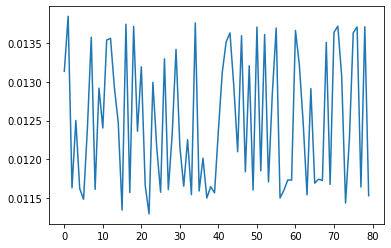

In [283]:
plt.plot(to_np(a.mean(dim=0)[0, 0]))

In [294]:
A = (Q@K.transpose(-1, -2))
a = A.mean(dim=-2, keepdim=True)

In [295]:
b = Q.mean(dim=-2, keepdim=True)@K.transpose(-1, -2)

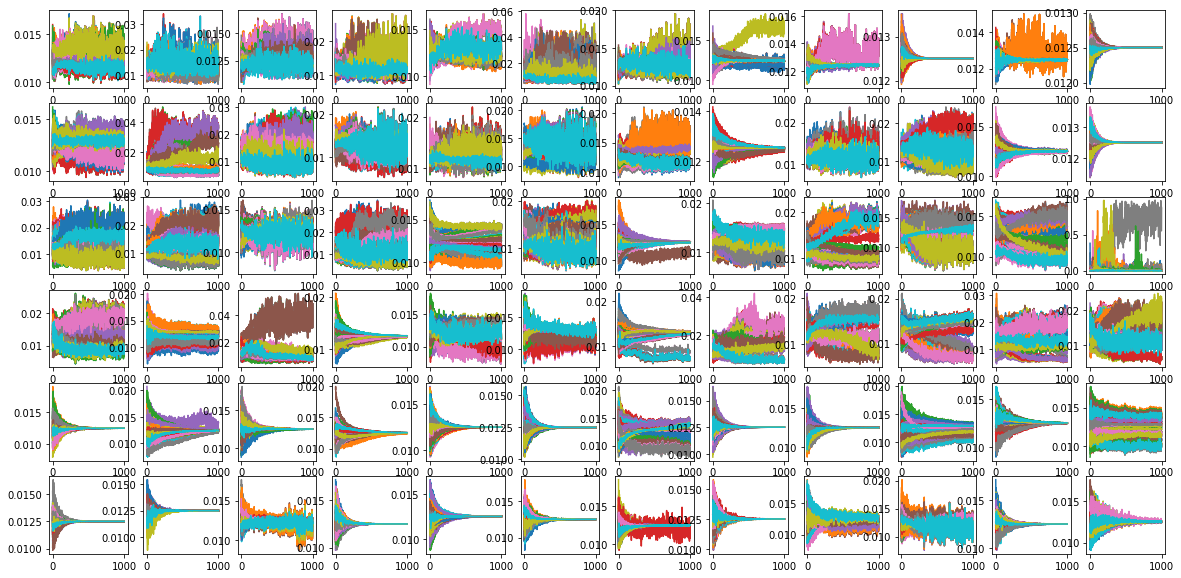

In [249]:
a = torch.stack(data['activation'])
plt.figure(figsize=(20, 10))
i=1
for idx_layer in range(6):
    for idx_head in range(12):
        plt.subplot(6, 12, i)
        plt.plot(to_np(a[:, idx_layer, idx_head, :]))
        i+=1

In [75]:
idx_layer_viz, idx_head_viz = 3, 0

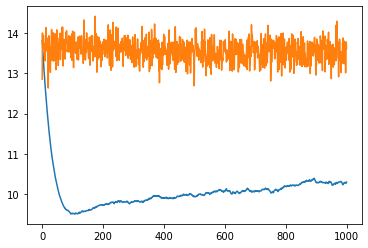

In [76]:
a = torch.stack(data['spread_Km'])
plt.plot(to_np(a[:, idx_layer_viz, idx_head_viz]))
a = torch.stack(data['spread_T'])
plt.plot(to_np(a[:, idx_layer_viz, idx_head_viz]))

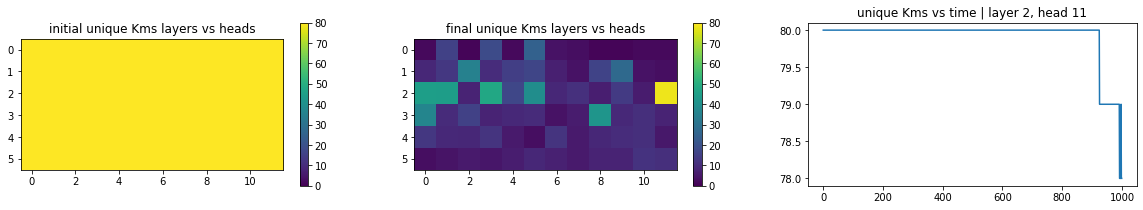

In [79]:
idx_layer_viz, idx_head_viz = 2, 11
a = torch.stack(data['n_unique_Km'])
plt.figure(figsize=(20,3))
plt.subplot(131); plt.title('initial unique Kms layers vs heads')
plt.imshow(to_np(a[0]), vmin=0, vmax=n_memories); plt.colorbar()
plt.subplot(132); plt.title('final unique Kms layers vs heads')
plt.imshow(to_np(a[-1]), vmin=0, vmax=n_memories); plt.colorbar()
plt.subplot(133); plt.title(f'unique Kms vs time | layer {idx_layer_viz}, head {idx_head_viz}')
plt.plot(to_np(a[:, idx_layer_viz, idx_head_viz]))

In [201]:
# model.forward(input_ids=input_ids_book[None, :100].to(device), past_key_values=None)